#  Word Embedding Demo

In this demo, we will guide you through the basic steps for creating word representations using skip-gram neural network architecture.

In your homework, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

The sample code for skip-gram model is given. Your job is to incorporate the tokenizer model that you created in HomeWork-1 to tokenize raw text and turn it into word vectors.

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 best categories)  (compare)


This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###

In [16]:
import matplotlib
import matplotlib.font_manager as fm

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')

--2021-02-17 05:20:11--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-02-17 05:20:11--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.1’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.002s  

2021-02-17 05:20:11 (53.6 MB/s) - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


In [17]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

## Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [18]:
!wget https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
!unzip -q wiki.zip

--2021-02-17 05:20:12--  https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n87fiy25f2yc3gt/wiki.zip [following]
--2021-02-17 05:20:13--  https://www.dropbox.com/s/raw/n87fiy25f2yc3gt/wiki.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8c3a66d7edb4fa708e190f53d.dl.dropboxusercontent.com/cd/0/inline/BJEDRaGjTaAIOxstOt9zcCMG2tg2YHp4nDylZnMuzVDJIsZEj_HoUONdiz-6Wl7ibExdXN2z1oG45DDA1yQ1JrdjsqY7kjPM1AxC1Bi8YWOKmt-r-pMfHKMCLLFGmGt5Wcc/file# [following]
--2021-02-17 05:20:13--  https://ucc8c3a66d7edb4fa708e190f53d.dl.dropboxusercontent.com/cd/0/inline/BJEDRaGjTaAIOxstOt9zcCMG2tg2YHp4nDylZnMuzVDJIsZEj_HoUONdiz-6Wl7ibExdXN2z1oG45DDA1yQ1JrdjsqY7kjPM1AxC1Bi8YWOKmt-r-pMfHKMC

In [41]:
#Step 1: read the wikipedia text file
with open("wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [42]:
print("total word count:", len(input_text))

total word count: 36349066


## Step 2: Indexing (Assign a number to each word)

The given code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary




Your job is to set a threshold for rare words and replace them with "UNK"

+ Please tell how you choose a number for your threshold

In [46]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text):
    
    words = [word for word in input_text ]
    word_count = list()
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    word_count.append(("UNK",0))

    #print out 10 most frequent words
    print(word_count[:10])
    
    dictionary = dict()
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        data.append(dictionary[word])

    return data, dictionary, reverse_dictionary

dataset, dictionary, reverse_dictionary=create_index(input_text)
del input_text #just to clear up some memory

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]


In [22]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [228, 207, 2452, 572, 14, 1828, 7148, 3123, 680, 23]
output sample (dictionary): {'ที่': 0, 'ใน': 1, 'เป็น': 2, 'และ': 3, 'การ': 4, 'มี': 5, 'ของ': 6, 'ได้': 7, ')': 8, '"': 9}
output sample (reverse dictionary): {0: 'ที่', 1: 'ใน', 2: 'เป็น', 3: 'และ', 4: 'การ', 5: 'มี', 6: 'ของ', 7: 'ได้', 8: ')', 9: '"'}


In [23]:
len(dictionary) #number of unique words

701355

# Step3: Create skip-grams (inputs for your model)


In [24]:
# Step 3: Create data samples 
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(sample_set)
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(sample_set)})
print(couples, labels)

# n = 8
n = len(labels)
for i in range(n):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]],labels[i])

[228, 207, 2452, 572, 14, 1828, 7148, 3123, 680, 23]
output sample (reverse dictionary): {228: 'หน้า', 207: 'หลัก', 2452: 'วิกิพีเดีย', 572: 'ดำเนินการ', 14: 'โดย', 1828: 'มูลนิธิ', 7148: 'วิกิ', 3123: 'มีเดีย', 680: 'องค์กร', 23: 'ไม่'}
[[207, 228], [3123, 7148], [3123, 471030], [2452, 571413], [2452, 207], [2452, 439899], [3123, 681454], [207, 2452], [207, 617890], [2452, 572], [3123, 680], [207, 231149]] [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0]
หลัก หน้า 1
มีเดีย วิกิ 1
มีเดีย พิลิก 0
วิกิพีเดีย เลือดฟลัก 0
วิกิพีเดีย หลัก 1
วิกิพีเดีย เบียนเดย์ 0
มีเดีย อินเตอร์ลิงกัว 0
หลัก วิกิพีเดีย 1
หลัก -Adi 0
วิกิพีเดีย ดำเนินการ 1
มีเดีย องค์กร 1
หลัก ปัจจุบันโดเมน 0


# Step 4: create the skip-gram model
![Skip-gram model](https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW3/skipgram.png)


In [25]:
#reference:  https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb

dim_embedddings = 32 #embedding dimension
V = len(dictionary) #Vocab size

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:w*c
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        22443360    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 32)        22443360    input_4[0][0]                    
____________________________________________________________________________________________

In [26]:
# Train for 5 epoch
# it will take roughly 3-4 hours for each epoch
# PRO TIPS: you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# for _ in range(5):
#     prev_i=0
#     #it is likely that your GPU won't be able to handle 36 million words
#     #just do it 100000 words at a time
    
#     for i in range(len(dataset)//100000):
#         #generate skipgrams
#         data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
#         x = [np.array(x) for x in zip(*data)]
#         y = np.array(labels, dtype=np.int32)
#         if x:
#             loss = SkipGram.train_on_batch(x, y)
#         prev_i = i 
#         print(loss,i*100000)



In [27]:
# SkipGram.save_weights('/data/my_skipgram32_weights.h5')

In [28]:
!wget https://www.dropbox.com/s/7vwvfuhuj90xmkt/my_skipgram32_weights.h5
SkipGram.load_weights('my_skipgram32_weights.h5')

--2021-02-17 05:23:56--  https://www.dropbox.com/s/7vwvfuhuj90xmkt/my_skipgram32_weights.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7vwvfuhuj90xmkt/my_skipgram32_weights.h5 [following]
--2021-02-17 05:23:56--  https://www.dropbox.com/s/raw/7vwvfuhuj90xmkt/my_skipgram32_weights.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb96bfd46ff585ad70767346b4c.dl.dropboxusercontent.com/cd/0/inline/BJEqFhfVus0o29DR5Jqs-K2b9GIVyY7RBOud_0-iS99oY5lPK-A-CtI4EUmrJ5RhJdGz8Fn6EZOlUMJB9RiMu-9GzfUG_Gr7O1BvfuHWACe4YQrPN_9fu_u6WQ-dbHyzKXU/file# [following]
--2021-02-17 05:23:56--  https://ucb96bfd46ff585ad70767346b4c.dl.dropboxusercontent.com/cd/0/inline/BJEqFhfVus0o29DR5Jqs-K2b9GIVyY7RBOud_0-iS99oY5lPK-A-CtI4EUmrJ5RhJdGz8Fn6EZO

In [29]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings.shape)
print(final_embeddings)

(701355, 32)
[[ 0.01071562 -0.01074328 -0.02531431 ...  0.03910271 -0.0368655
   0.03950372]
 [-0.7160194  -0.67405814 -0.7294304  ...  0.75417095 -0.75439006
   0.7170146 ]
 [-0.70340365 -0.7100235  -0.75649726 ...  0.7274267  -0.7430642
   0.7140636 ]
 ...
 [ 0.00662547  0.03747633  0.0425466  ... -0.00487729 -0.03569604
  -0.03677369]
 [ 0.00636204  0.0271068  -0.02475818 ... -0.03389449  0.01134787
  -0.01205122]
 [-0.03409064 -0.00323062 -0.0040661  ...  0.00075774  0.00768975
  -0.03359085]]


# Step 5: Visualize the embeddings

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is suited for the visualization of high-dimensional datasets. You don't need to understand t-SNE to complete this course, but it is a very powerful tool of visualizing your word vectors. You can read more about t-SNE here: https://lvdmaaten.github.io/tsne/

In [30]:
# Step 5: Visualize the embeddings.
# Function to draw visualization of distance between embeddings.
#reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
 
    plt.show()
    plt.savefig(filename)

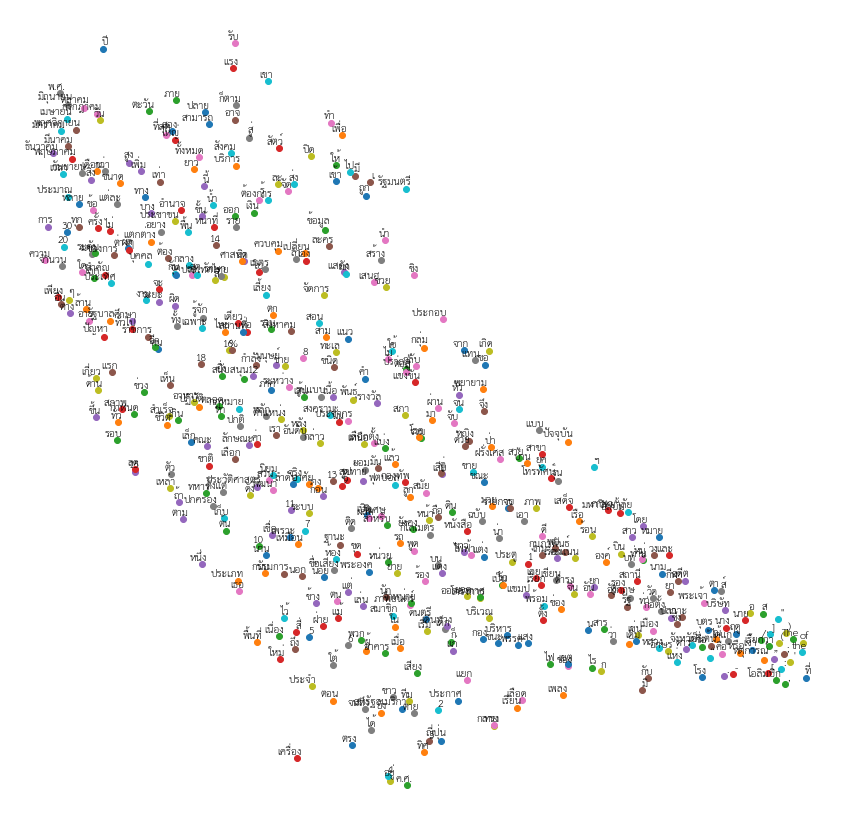

<Figure size 432x288 with 0 Axes>

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Visualization: Tensorboard

http://bit.ly/2s0SNHl 

In [32]:
#VISUALIZATION ON TENSORBOARD
#reference: https://github.com/keras-team/keras/pull/5247
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

#you need two files to represent data on tensorboard projector
#1 weights
#2 metadata 
import csv
with open('weights.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerows(final_embeddings[:10000])

with open('metadata.tsv', 'w') as tsvfile:
    for i in range(10000):
        tsvfile.write(reverse_dictionary[i]+"\n")

# Step 6: Evaluation
"Of course the most important evaluation metric for vector models is extrinsic evaluation
on tasks; adding them as features into any NLP task and seeing whether this
improves performance.

Nonetheless it is useful to have intrinsic evaluations. The most common metric
is to test their performance on similarity, and in particular on computing the
correlation between an algorithm’s word similarity scores and word similarity ratings
assigned by humans" - Dan Jarafsky (reference: https://web.stanford.edu/~jurafsky/slp3/15.pdf)

Cosine similarity is an important metric for measuring similarity between words. In this demo, we will guide you through some examples that you might be able to use to evaluate your models.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
#sci-kit learns provide a simple module that you can use to calculate cosine similarity
print(cosine_similarity(final_embeddings[dictionary["ธันวาคม"]].reshape(1, -1), final_embeddings[dictionary["ตุลาคม"]].reshape(1, -1)))

[[0.99809885]]


In [34]:
final_embeddings[dictionary["ประเทศไทย"]]

array([-0.7887928 , -0.7988995 , -0.80175483, -0.7222954 ,  0.74297917,
        0.7880666 ,  0.72824407, -0.7484419 , -0.8039316 , -0.74094427,
       -0.807812  , -0.7576262 , -0.77248174,  0.77461624, -0.7520463 ,
        0.7732355 , -0.72429633, -0.7350894 ,  0.7129753 , -0.7884581 ,
       -0.8168846 , -0.7384652 , -0.7556709 , -0.75231427,  0.75457186,
       -0.7856202 , -0.72242093, -0.71190906,  0.78026533,  0.73570675,
       -0.72323763,  0.7964383 ], dtype=float32)

In [35]:
import scipy
#scipy also provides you with a module that you can use to compare your target words against all the words in your corpus
v = final_embeddings[dictionary["สิงหาคม"]].reshape(1, -1)
#just compare with top 10000 words....
all_dist = scipy.spatial.distance.cdist(final_embeddings[:10000], v, 'cosine').reshape(-1)
# get 20 nearest vector 
# argpartition can get top twenty very quickly, but they are not sorted
idx =np.argpartition(all_dist, 20)[:20]
#sort
idx = idx[np.argsort(all_dist[idx[:20]])]
for i in idx:
    print(reverse_dictionary[i])

สิงหาคม
มีนาคม
กรกฎาคม
ยืน
1944
2553
มนุษย์
เรื่อง
1970
ยุโรป
เมตร
กันยายน
โรงงาน
พิธีกร
รัฐมนตรี
ห้อง
สูญหาย
เมษายน
ขัดแย้ง
กลอง


In [36]:
print(cosine_similarity(final_embeddings[dictionary["ประเทศไทย"]].reshape(1, -1), final_embeddings[dictionary["ประเทศญี่ปุ่น"]].reshape(1, -1)))
print(cosine_similarity(final_embeddings[dictionary["ประเทศไทย"]].reshape(1, -1), final_embeddings[dictionary["ไส้กรอก"]].reshape(1, -1)))

[[0.99825144]]
[[0.99547327]]


In [37]:
#to do any visualization you must reduce the dimension of your word vectors to 2D or 3D...
tsne2 = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 10000#only top 10000 words
low_dim_embs2 = tsne2.fit_transform(final_embeddings[:plot_only, :])

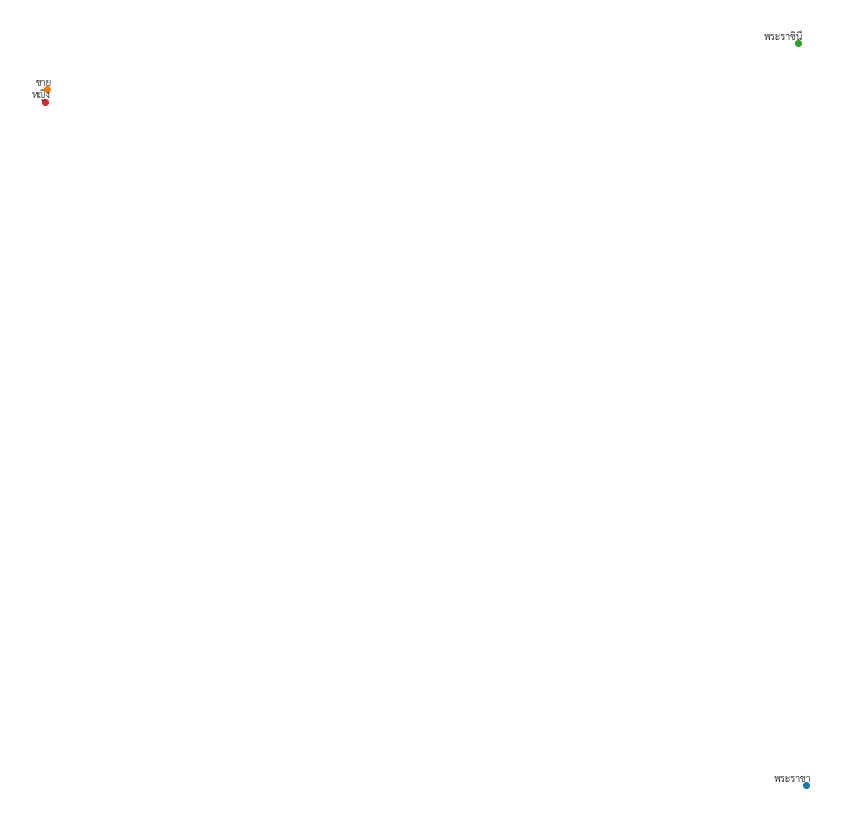

<Figure size 432x288 with 0 Axes>

In [38]:
#Visualizing the famous "king-male+female=queen" 
labels = [reverse_dictionary[i] for i in range(plot_only)]
word_list = ['พระราชา','ชาย','พระราชินี','หญิง']
idx_list = []
for word in word_list:
    idx_list.append(labels.index(word))
word_plot = low_dim_embs2[idx_list]
plot_with_labels(word_plot,word_list,filename="queen_king.png")